In [1]:
import os
import time
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from  Unet import UNet

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
classes = 1  # exclude background
weights_path = "./best_thrombus_model.pth"
# create model
model = UNet(in_channels=3, num_classes=classes+1, base_c=32, bilinear=False)
# load weights
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
model.to(device)

using cpu device.


UNet(
  (in_conv): DoubleConv(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Down(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dow

In [5]:
opacity = 0.3 # 透明度，越大越接近原图
mean = (0.541, 0.601, 0.692)
std = (0.096, 0.108, 0.142)

img_path = "./13.jpg"
# img_path = "/Users/chenchaofan/python_project/unet/data/thrombus/img_dir/val/2.jpg"

# load image
original_img = cv2.imread(img_path)

# from pil image to tensor and normalize
data_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])
img = data_transform(original_img)
# expand batch dimension
img_bgr = torch.unsqueeze(img, dim=0)

# 语义分割预测
model.eval()  # 进入验证模式
with torch.no_grad():
    # init model
    img_height, img_width = img_bgr.shape[-2:]
    init_img = torch.zeros((1, 3, img_height, img_width), device=device)
    model(init_img)
    output = model(img_bgr.to(device))
    prediction = output['out'].argmax(1).squeeze(0)
    pred_mask = prediction.to("cpu").numpy().astype(np.uint8)

In [6]:
np.expand_dims(pred_mask*255, axis=2).shape

(1440, 1920, 1)

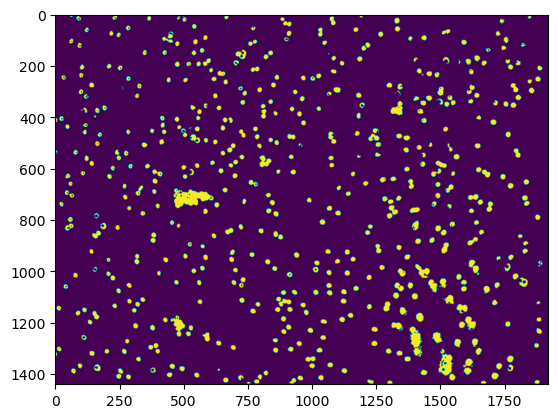

In [7]:
plt.imshow(pred_mask)

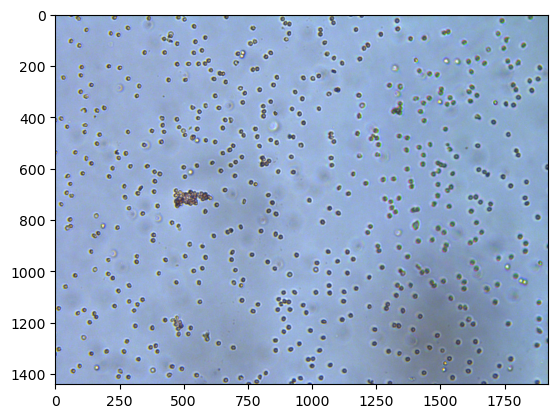

In [8]:
plt.imshow(original_img[:,:,::-1])

In [9]:
imgGray = pred_mask
# threshold1 , threshold2= 34, 99
# imgCanny = cv2.Canny(imgGray, threshold1, threshold2)
kernel = np.ones((7, 7))
imgDil = cv2.dilate(imgGray, kernel, iterations=10)
contours, hierarchy = cv2.findContours(imgGray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [10]:
imgContour = original_img.copy()
for cnt in contours:
    area = cv2.contourArea(cnt)
    # areaMin = cv2.getTrackbarPos("Area", "Parameters")
    areaMin = 4000
    if area > areaMin:
        cv2.drawContours(imgContour, cnt, -1, (255, 0, 255), 7)
        # 识别是几边形状
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        print(len(approx))
        #
        # 画矩阵框
        x , y , w, h = cv2.boundingRect(approx)
        cv2.rectangle(imgContour, (x , y ), (x + w , y + h ), (0, 255, 0), 5)
        
        cv2.putText(imgContour, "Points: " + str(len(approx)), (x + w + 20, y + 20), cv2.FONT_HERSHEY_COMPLEX, .7,
                    (0, 255, 0), 2)
        cv2.putText(imgContour, "Area: " + str(int(area)), (x + w + 20, y + 45), cv2.FONT_HERSHEY_COMPLEX, 0.7,
                    (0, 255, 0), 2)

8


34


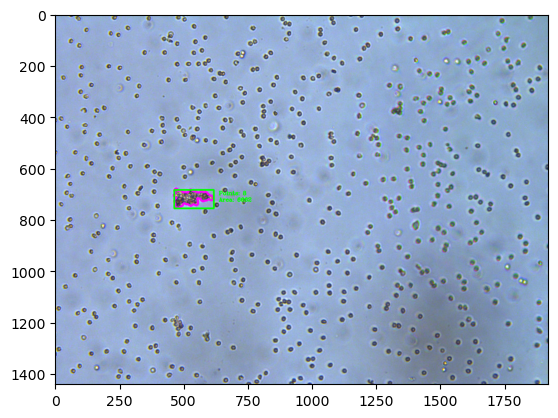

In [11]:
plt.imshow(imgContour[:,:,::-1])
print(len(cnt))

In [27]:
def get_thrombus_mask(img_path="./13.jpg"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))
    classes = 1  # exclude background
    weights_path = "./best_thrombus_model.pth"
    # create model
    model = UNet(in_channels=3, num_classes=classes + 1, base_c=32, bilinear=False)
    # load weights
    model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
    model.to(device)
    mean = (0.541, 0.601, 0.692)
    std = (0.096, 0.108, 0.142)
    # load image
    original_img = cv2.imread(img_path)
    # from pil image to tensor and normalize
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=mean, std=std)])
    img = data_transform(original_img)
    # expand batch dimension
    img_bgr = torch.unsqueeze(img, dim=0)
    # 语义分割预测
    model.eval()  # 进入验证模式
    with torch.no_grad():
        # init model
        img_height, img_width = img_bgr.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)
        output = model(img_bgr.to(device))
        prediction = output['out'].argmax(1).squeeze(0)
        pred_mask = prediction.to("cpu").numpy().astype(np.uint8)
    pred_mask = pred_mask * 255

    return pred_mask

In [28]:
img_path = "./14.jpg"
pred_mask = get_thrombus_mask(img_path=img_path)

using cpu device.


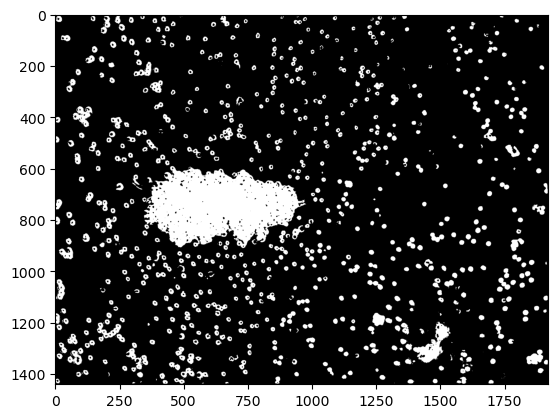

In [29]:
plt.imshow(pred_mask, cmap="gray")

In [59]:
def get_thrombus_ploy(pred_mask):
    imgGray = pred_mask
    # kernel = np.ones((7, 7))
    # imgGray = cv2.dilate(imgGray, kernel, iterations=20)
    contours, hierarchy = cv2.findContours(imgGray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ploy = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # areaMin = cv2.getTrackbarPos("Area", "Parameters")
        areaMin = 10000
        if area > areaMin:
            # 识别是几边形状
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)
            ploy.append(approx.reshape(-1,2))
            print(f"血栓的形状为：{len(approx)}多边形")
    
    return ploy[0]
            

In [60]:
ploy = get_thrombus_ploy(pred_mask=pred_mask)

血栓的形状为：9多边形


In [61]:
ploy.shape

(9, 2)

In [62]:
ori_img = cv2.imread(img_path)
ori_img = cv2.polylines(ori_img, [ploy], isClosed=True, color=(0,0,255), thickness=10)

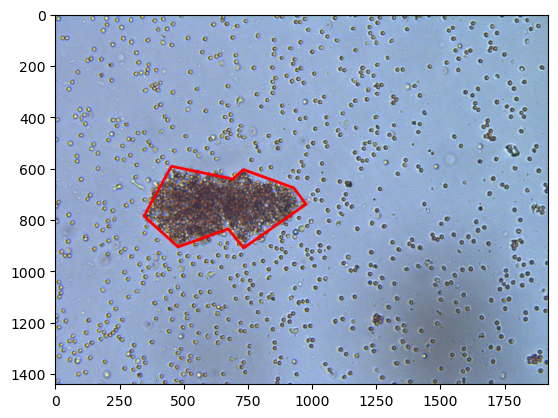

In [63]:
plt.imshow(ori_img[:,:,::-1])

In [66]:
from SweepPlanner import planning
def get_cover_planning(ploy):
    ox, oy = [point[0] for point in ploy],[point[1] for point in ploy]
    resolution = 10.0
    px, py = planning(ox, oy, resolution)
    return px, py

In [67]:
def show_animation():
    img_path = "./14.jpg"
    ori_img = cv2.imread(img_path)
    pred_mask = get_thrombus_mask(img_path=img_path)
    ploy = get_thrombus_ploy(pred_mask=pred_mask)
    px, py = get_cover_planning(ploy)


    ox, oy = [point[0] for point in ploy],[point[1] for point in ploy]
    for ipx, ipy in zip(px, py):
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(ox, oy, "-xb")
        plt.plot(px, py, "-r")
        plt.plot(ipx, ipy, "or")
        plt.axis("equal")
        # plt.grid(True)
        plt.pause(0.1)
        
    plt.cla()
    plt.plot(ox, oy, "-xb")
    plt.plot(px, py, "-r")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)
    plt.close()

In [69]:
show_animation()

using cpu device.


KeyboardInterrupt: 